介绍如何在pytorch环境下，使用JSMA算法攻击基于ImageNet数据集预训练的alexnet模型。

Jupyter notebook中使用Anaconda中的环境需要单独配置，默认情况下使用的是系统默认的Python环境，以使用advbox环境为例。
首先在默认系统环境下执行以下命令，安装ipykernel。

    conda install ipykernel
    conda install -n advbox ipykernel

在advbox环境下激活，这样启动后就可以在界面上看到advbox了。

    python -m ipykernel install --user --name advbox --display-name advbox 


In [1]:
#打开调试日志
import logging
logging.basicConfig(level=logging.INFO,format="%(filename)s[line:%(lineno)d] %(levelname)s %(message)s")
logger=logging.getLogger(__name__)

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
from advbox.adversary import Adversary
from advbox.attacks.saliency import JSMA
from advbox.models.pytorch import PytorchModel
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#定义被攻击的图片
image_path="tutorials/cropped_panda.jpg"

In [3]:
# Define what device we are using
logging.info("CUDA Available: {}".format(torch.cuda.is_available()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#cv2默认读取格式为bgr bgr -> rgb   
orig = cv2.imread(image_path)[..., ::-1]
#转换成224*224
orig = cv2.resize(orig, (224, 224))
adv=None
img = orig.copy().astype(np.float32)

#图像数据标准化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std

#pytorch中图像格式为CHW  
#[224,224,3]->[3,224,224]
img = img.transpose(2, 0, 1)

img = Variable(torch.from_numpy(img).to(device).float().unsqueeze(0)).cpu().numpy()


# Initialize the network
#Alexnet
model = models.alexnet(pretrained=True).to(device).eval()

#print(model)

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

# advbox demo
m = PytorchModel(
    model, None,(-3, 3),
    channel_axis=1)

#实例化JSMA max_iter为最大迭代次数  theta为扰动系数 max_perturbations_per_pixel为单像素最大修改次数
attack = JSMA(m)
attack_config = {
        "max_iter": 2000,
        "theta": 0.3,
        "max_perturbations_per_pixel": 7,
        "fast":True,
        "two_pix":False
}


inputs=img
labels = None

print(inputs.shape)

adversary = Adversary(inputs, labels)

#定向攻击
tlabel = 538
adversary.set_target(is_targeted_attack=True, target_label=tlabel)


adversary = attack(adversary, **attack_config)

if adversary.is_successful():
    print(
        'attack success, adversarial_label=%d'
        % (adversary.adversarial_label))

    adv=adversary.adversarial_example[0]

else:
    print('attack failed')


print("jsma attack done")

<ipython-input-3-009d082b2646>[line:2] INFO CUDA Available: False
pytorch.py[line:66] INFO Finish PytorchModel init
base.py[line:87] INFO adversary:
         original_label: 388
         target_label: 538
         is_targeted_attack: True
saliency.py[line:87] INFO step = 0, original_label = 388, adv_label=388 logit=-3.97655725479


cpu
(1, 3, 224, 224)


saliency.py[line:87] INFO step = 1, original_label = 388, adv_label=388 logit=-3.96179437637
saliency.py[line:87] INFO step = 2, original_label = 388, adv_label=388 logit=-3.9705016613
saliency.py[line:121] INFO adv_img[idx] 3.00308132172 is over
saliency.py[line:87] INFO step = 3, original_label = 388, adv_label=388 logit=-3.99984383583
saliency.py[line:87] INFO step = 4, original_label = 388, adv_label=388 logit=-3.96096515656
saliency.py[line:87] INFO step = 5, original_label = 388, adv_label=388 logit=-3.94387102127
saliency.py[line:87] INFO step = 6, original_label = 388, adv_label=388 logit=-3.91530132294
saliency.py[line:87] INFO step = 7, original_label = 388, adv_label=388 logit=-3.88175773621
saliency.py[line:87] INFO step = 8, original_label = 388, adv_label=388 logit=-3.90859127045
saliency.py[line:87] INFO step = 9, original_label = 388, adv_label=388 logit=-3.83491182327
saliency.py[line:121] INFO adv_img[idx] 4.05028009415 is over
saliency.py[line:87] INFO step = 10, ori

saliency.py[line:87] INFO step = 78, original_label = 388, adv_label=388 logit=-1.80938887596
saliency.py[line:87] INFO step = 79, original_label = 388, adv_label=388 logit=-1.78918254375
saliency.py[line:87] INFO step = 80, original_label = 388, adv_label=388 logit=-1.77211487293
saliency.py[line:87] INFO step = 81, original_label = 388, adv_label=388 logit=-1.73850846291
saliency.py[line:87] INFO step = 82, original_label = 388, adv_label=388 logit=-1.67633092403
saliency.py[line:87] INFO step = 83, original_label = 388, adv_label=388 logit=-1.66609013081
saliency.py[line:87] INFO step = 84, original_label = 388, adv_label=388 logit=-1.61802899837
saliency.py[line:87] INFO step = 85, original_label = 388, adv_label=388 logit=-1.59684574604
saliency.py[line:87] INFO step = 86, original_label = 388, adv_label=388 logit=-1.55499505997
saliency.py[line:87] INFO step = 87, original_label = 388, adv_label=388 logit=-1.53600263596
saliency.py[line:87] INFO step = 88, original_label = 388, a

saliency.py[line:87] INFO step = 159, original_label = 388, adv_label=153 logit=-0.358267903328
saliency.py[line:87] INFO step = 160, original_label = 388, adv_label=153 logit=-0.378948569298
saliency.py[line:121] INFO adv_img[idx] 4.27465009689 is over
saliency.py[line:87] INFO step = 161, original_label = 388, adv_label=153 logit=-0.371035516262
saliency.py[line:87] INFO step = 162, original_label = 388, adv_label=153 logit=-0.343400776386
saliency.py[line:87] INFO step = 163, original_label = 388, adv_label=153 logit=-0.322207987309
saliency.py[line:121] INFO adv_img[idx] 3.65884065628 is over
saliency.py[line:87] INFO step = 164, original_label = 388, adv_label=153 logit=-0.305791676044
saliency.py[line:121] INFO adv_img[idx] 3.05567264557 is over
saliency.py[line:87] INFO step = 165, original_label = 388, adv_label=153 logit=-0.277698040009
saliency.py[line:87] INFO step = 166, original_label = 388, adv_label=153 logit=-0.337258815765
saliency.py[line:87] INFO step = 167, original

saliency.py[line:87] INFO step = 234, original_label = 388, adv_label=153 logit=1.02352142334
saliency.py[line:87] INFO step = 235, original_label = 388, adv_label=153 logit=1.04485571384
saliency.py[line:87] INFO step = 236, original_label = 388, adv_label=153 logit=1.07976198196
saliency.py[line:87] INFO step = 237, original_label = 388, adv_label=153 logit=1.10686004162
saliency.py[line:87] INFO step = 238, original_label = 388, adv_label=153 logit=1.1598585844
saliency.py[line:121] INFO adv_img[idx] 4.52296924591 is over
saliency.py[line:87] INFO step = 239, original_label = 388, adv_label=153 logit=1.16542422771
saliency.py[line:87] INFO step = 240, original_label = 388, adv_label=153 logit=1.17010235786
saliency.py[line:87] INFO step = 241, original_label = 388, adv_label=153 logit=1.2002414465
saliency.py[line:87] INFO step = 242, original_label = 388, adv_label=153 logit=1.22429013252
saliency.py[line:87] INFO step = 243, original_label = 388, adv_label=153 logit=1.26407968998


saliency.py[line:87] INFO step = 315, original_label = 388, adv_label=712 logit=3.20123696327
saliency.py[line:87] INFO step = 316, original_label = 388, adv_label=712 logit=3.20767140388
saliency.py[line:87] INFO step = 317, original_label = 388, adv_label=712 logit=3.21089267731
saliency.py[line:87] INFO step = 318, original_label = 388, adv_label=712 logit=3.24746847153
saliency.py[line:87] INFO step = 319, original_label = 388, adv_label=712 logit=3.23471498489
saliency.py[line:87] INFO step = 320, original_label = 388, adv_label=712 logit=3.30864787102
saliency.py[line:87] INFO step = 321, original_label = 388, adv_label=153 logit=3.3368434906
saliency.py[line:87] INFO step = 322, original_label = 388, adv_label=712 logit=3.32553744316
saliency.py[line:121] INFO adv_img[idx] 4.58422660828 is over
saliency.py[line:87] INFO step = 323, original_label = 388, adv_label=712 logit=3.33337116241
saliency.py[line:87] INFO step = 324, original_label = 388, adv_label=712 logit=3.37874984741

saliency.py[line:121] INFO adv_img[idx] 3.6683473587 is over
saliency.py[line:87] INFO step = 388, original_label = 388, adv_label=971 logit=4.95058345795
saliency.py[line:121] INFO adv_img[idx] 3.35322141647 is over
saliency.py[line:87] INFO step = 389, original_label = 388, adv_label=971 logit=4.99006175995
saliency.py[line:121] INFO adv_img[idx] 3.31820726395 is over
saliency.py[line:87] INFO step = 390, original_label = 388, adv_label=971 logit=4.95807552338
saliency.py[line:87] INFO step = 391, original_label = 388, adv_label=971 logit=4.99743700027
saliency.py[line:87] INFO step = 392, original_label = 388, adv_label=971 logit=5.08588409424
saliency.py[line:87] INFO step = 393, original_label = 388, adv_label=971 logit=5.14187002182
saliency.py[line:121] INFO adv_img[idx] 3.35322141647 is over
saliency.py[line:87] INFO step = 394, original_label = 388, adv_label=971 logit=5.18511486053
saliency.py[line:121] INFO adv_img[idx] 3.3007004261 is over
saliency.py[line:87] INFO step = 3

saliency.py[line:87] INFO step = 459, original_label = 388, adv_label=466 logit=6.67675924301
saliency.py[line:87] INFO step = 460, original_label = 388, adv_label=466 logit=6.72162437439
saliency.py[line:121] INFO adv_img[idx] 4.52296924591 is over
saliency.py[line:87] INFO step = 461, original_label = 388, adv_label=466 logit=6.73210525513
saliency.py[line:87] INFO step = 462, original_label = 388, adv_label=466 logit=6.73072528839
saliency.py[line:87] INFO step = 463, original_label = 388, adv_label=466 logit=6.74181175232
saliency.py[line:87] INFO step = 464, original_label = 388, adv_label=466 logit=6.78701162338
saliency.py[line:87] INFO step = 465, original_label = 388, adv_label=466 logit=6.77507352829
saliency.py[line:87] INFO step = 466, original_label = 388, adv_label=466 logit=6.82346630096
saliency.py[line:87] INFO step = 467, original_label = 388, adv_label=466 logit=6.81666374207
saliency.py[line:121] INFO adv_img[idx] 3.75968837738 is over
saliency.py[line:87] INFO step

attack success, adversarial_label=538
jsma attack done


In [4]:
#格式转换
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


l0=406 l2=2182.05522387


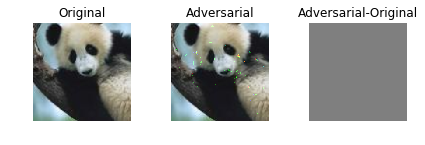

In [5]:
#显示原始图片  抵抗样本 以及两张图之间的差异  其中灰色代表没有差异的像素点
show_images_diff(orig,adversary.original_label,adv,adversary.adversarial_label)

相对FGSM、DeepFool，JSMA修改的像素个数少，即l0非常小